In [1]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from tensorflow.keras.optimizers import RMSprop

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd

import os
import sys
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils as ku
import keras.layers as kl
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Activation, Dense, LSTM, Conv2D, Reshape, dot, Lambda, Dropout, MaxPooling2D
from keras.optimizers import SGD
from itertools import islice
from tensorflow.keras.layers import Flatten
from keras.models import model_from_json
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.sequence import TimeseriesGenerator


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import math
import random
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, EarlyStopping
from datetime import *
from tensorflow.keras import optimizers
from keras.backend import int_shape
pd.set_option('display.max_colwidth',25)
from keras import backend as K
#from tensorflow.keras.layers import concatenate
#K.clear_session()

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import pathlib
rando_seed = 1234
np.random.seed(rando_seed)
#os.chdir('/media/alex/easystore/ids_monthly/BLM_images/2014_11_12')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

2023-01-20 00:39:38.734526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-01-20 00:39:38.734564: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
#cols = ['tweet_id', 'date', 'text', 'support', 'hashtags', 'users', 'urls', 'media_urls', 'nfollowers', 'nfriends', 'file_name', 'path']

#DATA = pd.read_csv('./meta_image_dataset_2020.csv', dtype = {'doc_id':str, 'picfiles':str,'label':int})
DATA = pd.read_csv('./elections_june21.csv', dtype = {'doc_id':str, 'picfiles':str,'label':str})
DATA.head()

,doc_id,picfiles,label,text,placename,features,ctext,path
0,782073868714246144,G8-PA5KA_400x400.jpg,0,Whew... We really got...,Wichita,whew ... we really go...,Whew... We really got...,/home/ajpineda/labim_...
1,782073940667662336,NMhckQKT_400x400.jpg,0,EVRRYBODY GO VOTE!!!!...,Douglasville,evrrybody go vote ! !...,EVRRYBODY GO VOTE!!!!...,/home/ajpineda/labim_...
2,782076821789564928,CtpUYoiUsAAv2-9.jpg,0,Young campaign organi...,Fort Collins,young campaign organi...,Young campaign organi...,/home/ajpineda/labim_...
3,782069425524486144,RsRIuF_8_400x400.jpeg,0,Interesting!! @Vesse...,Castle Rock,interesting ! ! @ ves...,Interesting!! @Vesse...,/home/ajpineda/labim_...
4,782080845171470336,ce1d0d2a1c28c4ac2c589...,0,One more day left be ...,Kansas,one more day left be ...,One more day left be ...,/home/ajpineda/labim_...


In [4]:
DATA.dtypes

doc_id       object
picfiles     object
label        object
text         object
placename    object
features     object
ctext        object
path         object
dtype: object

In [5]:
DATA['label'] = DATA['label'].map(str)
DATA.dtypes

doc_id       object
picfiles     object
label        object
text         object
placename    object
features     object
ctext        object
path         object
dtype: object

In [6]:
DATA = DATA.dropna(subset=['label'])
DATA.groupby('label').count()


,doc_id,picfiles,text,placename,features,ctext,path
label,,,,,,,
0,7441,7441,7441,7441,7441,7441,7441
1,1540,1540,1540,1540,1540,1540,1540


In [7]:
# must be divisible by batch size (50)

remove_n = 31
drop_indices = np.random.choice(DATA.index, remove_n, replace=False)
DATA = DATA.drop(drop_indices)
len(DATA)



8950

In [8]:
DATA.head()

,doc_id,picfiles,label,text,placename,features,ctext,path
0,782073868714246144,G8-PA5KA_400x400.jpg,0,Whew... We really got...,Wichita,whew ... we really go...,Whew... We really got...,/home/ajpineda/labim_...
1,782073940667662336,NMhckQKT_400x400.jpg,0,EVRRYBODY GO VOTE!!!!...,Douglasville,evrrybody go vote ! !...,EVRRYBODY GO VOTE!!!!...,/home/ajpineda/labim_...
2,782076821789564928,CtpUYoiUsAAv2-9.jpg,0,Young campaign organi...,Fort Collins,young campaign organi...,Young campaign organi...,/home/ajpineda/labim_...
3,782069425524486144,RsRIuF_8_400x400.jpeg,0,Interesting!! @Vesse...,Castle Rock,interesting ! ! @ ves...,Interesting!! @Vesse...,/home/ajpineda/labim_...
4,782080845171470336,ce1d0d2a1c28c4ac2c589...,0,One more day left be ...,Kansas,one more day left be ...,One more day left be ...,/home/ajpineda/labim_...


In [9]:
#Shuffle data

DATA = DATA.sample(frac=1, random_state=1234).reset_index(drop=True)
DATA.head()

,doc_id,picfiles,label,text,placename,features,ctext,path
0,792023316278149121,Cv3VARcWcAAK-8v.jpg,1,We're voting early! #...,Boston City Hall,we 're voting early !...,We're voting early! #...,/home/ajpineda/labim_...
1,793161035888721920,CwHfwREVIAA2RY9.jpg,0,@Jenny_Trout we will....,Los Angeles,@ jenny_trout we will...,@Jenny_Trout we will....,/home/ajpineda/labim_...
2,789634976090247169,CvUYzy2WEAQ41jk.jpg,1,They do know we don't...,San Francisco,they do know we do n'...,They do know we don't...,/home/ajpineda/labim_...
3,786754155738075138,KrZhjkpH_400x400.jpg,0,@HillaryClinton @HFA ...,Lynnwood,@ hillaryclinton @ hf...,@HillaryClinton @HFA ...,/home/ajpineda/labim_...
4,789418395041234944,WfFHBfrG_400x400.jpg,0,Wow! Going to miss th...,Virginia,wow ! going to miss t...,Wow! Going to miss th...,/home/ajpineda/labim_...


In [10]:
# Validation data: check for overfitting


val_data = DATA.sample(n=500, replace=False, weights=None, random_state=1234, axis=None)

# drop before sampling test data
DATA = DATA.drop(val_data.index)


# Test data: final model's prediction power
test_data = DATA.sample(n=500, replace=False, weights=None, random_state=1234, axis=None)
len(val_data)

500

In [11]:
test_data.groupby('label').count()

,doc_id,picfiles,text,placename,features,ctext,path
label,,,,,,,
0,406,406,406,406,406,406,406
1,94,94,94,94,94,94,94


In [12]:
# Validation data used to check for overfitting

val_data = DATA.sample(n=500, replace=False, weights=None, random_state=1234, axis=None)
train_data = DATA.drop(val_data.index)
len(val_data)

500

In [13]:
len(train_data)
train_data.groupby('label').count()

,doc_id,picfiles,text,placename,features,ctext,path
label,,,,,,,
0,6611,6611,6611,6611,6611,6611,6611
1,1339,1339,1339,1339,1339,1339,1339


In [ ]:
#os.chdir('/media/alex/easystore/ids_monthly/BLM_images/apsa_sample3')

In [14]:
##############################################################
###### TEXT PRE-PROCESSING ###############################


# PARAMETERS
#MAX_SEQUENCE_LENGTH = 30
MAX_NUM_WORDS = 6000
EMBEDDING_DIM = 100
#VALIDATION_SPLIT = 0.2


# SUBSET TO ONLY DATA AND LABELS
train_data_text = train_data[['features','label']]
train_labels_text = train_data['label'].values
train_data_text.head()

val_data_text = val_data[['features','label']]
val_labels_text = val_data['label'].values
val_data_text.head()

test_data_text = test_data[['features','label']]
test_labels_text = test_data['label'].values
test_data_text.head()

,features,label
1543,trump and hillary are...,0
4303,huh ? early voting li...,1
1283,waiting to cast my vo...,1
2009,the guy recording is ...,0
3809,the rude lying govern...,0


In [15]:
len(val_labels_text)

500

In [16]:
# tokenizers for training text data
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True,split=' ')
tokenizer.fit_on_texts(train_data_text['features'].values)
sequences = tokenizer.texts_to_sequences(train_data_text['features'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

train_data_text = pad_sequences(sequences)
train_labels_text = ku.to_categorical(np.asarray(train_labels_text))

print('Shape of train data tensor:', train_data_text.shape)
print('Shape of train label tensor:', train_labels_text.shape)


##########################################################################
# tokenizers for val text data


#tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True,split=' ')
#tokenizer.fit_on_texts(val_data_text['text'].values)
val_sequences = tokenizer.texts_to_sequences(val_data_text['features'].values)

word_index = tokenizer.word_index
print('Found %s unique val tokens.' % len(word_index))

val_data_text = pad_sequences(val_sequences)
val_labels_text = ku.to_categorical(np.asarray(val_labels_text))

#print('Shape of val data tensor:', val_data_text.shape)
#print('Shape of val label tensor:', val_labels_text.shape)

##########################################################################
# tokenizers for test text data


#tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, lower=True,split=' ')
#tokenizer.fit_on_texts(val_data_text['text'].values)
test_sequences = tokenizer.texts_to_sequences(test_data_text['features'].values)

word_index = tokenizer.word_index
print('Found %s unique val tokens.' % len(word_index))

test_data_text = pad_sequences(test_sequences)
test_labels_text = ku.to_categorical(np.asarray(test_labels_text))

display('Shape of test data tensor:', test_data_text.shape)
display('Shape of test label tensor:', test_labels_text.shape)

Found 20180 unique tokens.
Shape of train data tensor: (7950, 186)
Shape of train label tensor: (7950, 2)
Found 20180 unique val tokens.
Found 20180 unique val tokens.


'Shape of test data tensor:'

(500, 88)

'Shape of test label tensor:'

(500, 2)

In [17]:
print('Shape of val data tensor:', val_data_text.shape)
print('Shape of val label tensor:', val_labels_text.shape)

Shape of val data tensor: (500, 88)
Shape of val label tensor: (500, 2)


In [18]:
#print(word_index.keys())
train_data_text

array([[   0,    0,    0, ...,   16,   19, 2957],
       [   0,    0,    0, ..., 1994,  271,  131],
       [   0,    0,    0, ...,  644,   65,  183],
       ...,
       [   0,    0,    0, ...,    1,  214, 1482],
       [   0,    0,    0, ...,   25,    8,   26],
       [   0,    0,    0, ...,   15,  539,   35]], dtype=int32)

In [19]:
trainsetsize = len(train_data)
print('Number of training observations: ' + str(trainsetsize))

Number of training observations: 7950


In [20]:
valsetsize = len(val_data)
print('Number of val observations: ' + str(valsetsize))

Number of val observations: 500



"""
# Scaling Text Data

from sklearn.preprocessing import StandardScaler

dat_sets = [train_data_text, val_data_text, test_data_text]


def scale_mydata(X_train):

    scaler = StandardScaler().fit(X_train)
    scaler
    # out: StandardScaler()

    print(scaler.mean_)

    print(scaler.scale_)


    X_scaled = scaler.transform(X_train)
    return X_scaled


for dat in dat_sets:
    
    
    scale_mydata(dat)

train_data_text2 = scale_mydata(train_data_text)
val_data_text2 = scale_mydata(val_data_text)
test_data_text2 = scale_mydata(test_data_text)

"""


In [21]:

# Loading embeddings from Stanford NLP
# Good rundown of source code: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

# First, build index mapping words in the embeddings set
# to their embedding vector

# glove.twitter.27B.100d.txt
# glove.6B.100d.txt

print("Loading embeddings.")

embeddings_index = dict()
#texts = []
f = open('glove.6B.100d.txt', errors='ignore')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
#    texts.append(word)
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))





Loading embeddings.
Loaded 400000 word vectors.


In [22]:
list(embeddings_index.items())[15]

('was',
 array([ 1.3717e-01, -5.4287e-01,  1.9419e-01, -2.9953e-01,  1.7545e-01,
         8.4672e-02,  6.7752e-01,  9.8295e-02, -3.5611e-02,  2.1334e-01,
         5.1663e-01,  2.0687e-01,  4.4082e-01, -3.3655e-01,  5.6025e-01,
        -6.8790e-01,  5.1957e-01, -2.1258e-01, -5.2708e-01, -1.2249e-01,
         3.3099e-01,  2.6448e-02,  5.9007e-01,  6.5469e-03,  4.5405e-01,
        -3.3884e-01, -2.8261e-01, -2.4633e-01,  1.0847e-01,  3.1640e-01,
        -1.5368e-01,  7.3503e-01,  1.1858e-01,  7.0842e-01,  7.5081e-02,
         2.9738e-01, -1.1395e-01,  4.0807e-01, -4.2531e-02, -2.1301e-01,
        -7.9849e-01, -1.2703e-01,  7.5200e-01, -4.1746e-01,  4.6615e-01,
        -3.9097e-02,  6.5961e-01, -3.2336e-01,  4.4200e-01, -9.4137e-01,
        -2.3125e-01, -3.0604e-01,  7.9912e-01,  1.4581e+00, -8.8199e-01,
        -3.0041e+00, -7.5243e-01, -2.0503e-01,  1.1998e+00,  9.4881e-01,
         3.0649e-01,  4.8411e-01, -7.5720e-01,  6.5856e-01,  7.0107e-01,
        -9.3141e-01,  5.2928e-01,  2.3323e-

In [23]:
# At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:


print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=29,
                            trainable=False)



Preparing embedding matrix.


In [ ]:
#from tensorflow.keras.applications import inception_v3

In [24]:
###########################################################################
########## MODEL CONSTRUCTION #############################################



sequence_input = Input(shape=(None, ), dtype='int64')
embedded_sequences = embedding_layer(sequence_input)
x_text = Conv1D(32, kernel_size = 5, activation="relu", padding = 'same')(embedded_sequences)
x_text = MaxPooling1D(5)(x_text)
x_text = Conv1D(32, kernel_size = 5, activation="relu", padding = 'same')(x_text)
x_text = GlobalMaxPooling1D()(x_text)
#x_text = Dense(16, activation="relu")(x_text)
#x_text = Dropout(0.5)(x_text)
x = Dense(64, activation='relu')(x_text)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(8, activation='relu')(x)
x = Dense(4, activation='relu')(x)
preds = Dense(2, activation='sigmoid')(x_text)


model = keras.Model(sequence_input, preds)
#model.summary()

tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=False)


print("Begin training...")

sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.95, nesterov=True, clipvalue=.5)

model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics = ['categorical_accuracy'])

Begin training...


2022-09-16 14:07:12.437785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-09-16 14:07:12.437817: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-16 14:07:12.437835: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gl3118.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist
2022-09-16 14:07:12.438413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ajpineda/.local/lib/python3.9/site-packages/keras

In [25]:


history = model.fit(train_data_text, train_labels_text, batch_size=50, epochs=50, validation_data=(val_data_text, val_labels_text))

Epoch 1/50
159/159 [==============================] - 10s 57ms/step - loss: 0.3488 - categorical_accuracy: 0.8542 - val_loss: 0.3187 - val_categorical_accuracy: 0.8460
Epoch 2/50
159/159 [==============================] - 8s 51ms/step - loss: 0.2641 - categorical_accuracy: 0.8869 - val_loss: 0.2915 - val_categorical_accuracy: 0.8700
Epoch 3/50
159/159 [==============================] - 8s 53ms/step - loss: 0.2271 - categorical_accuracy: 0.9044 - val_loss: 0.3082 - val_categorical_accuracy: 0.8620
Epoch 4/50
159/159 [==============================] - 8s 52ms/step - loss: 0.1988 - categorical_accuracy: 0.9187 - val_loss: 0.3244 - val_categorical_accuracy: 0.8660
Epoch 5/50
159/159 [==============================] - 8s 52ms/step - loss: 0.1722 - categorical_accuracy: 0.9274 - val_loss: 0.3161 - val_categorical_accuracy: 0.8620
Epoch 6/50
159/159 [==============================] - 8s 51ms/step - loss: 0.1363 - categorical_accuracy: 0.9450 - val_loss: 0.3351 - val_categorical_accuracy: 0.85

In [3]:
#model.load('elections_text_916.h5')  # c

model1 = load_model('elections_text_916.h5')
model1.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         600100    
                                                                 
 conv1d (Conv1D)             (None, None, 32)          16032     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                              

2023-01-20 00:40:56.261784: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-01-20 00:40:56.261818: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-20 00:40:56.261831: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gl3185.arc-ts.umich.edu): /proc/driver/nvidia/version does not exist
2023-01-20 00:40:56.262011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


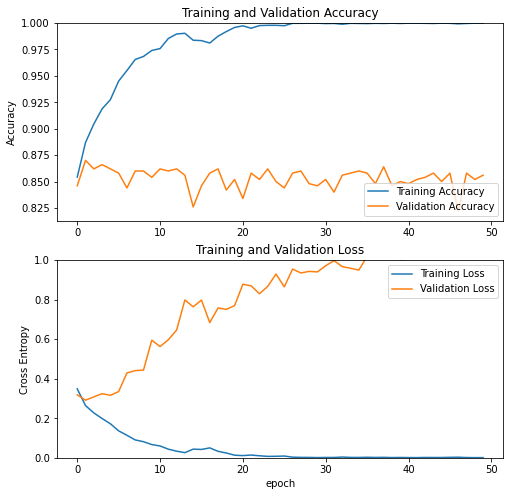

In [28]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')

plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

#plt.savefig(train_file_name)
plt.show()

In [29]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions')
test_predictions = model.predict(test_data_text)
train_predictions = model.predict(train_data_text)


# Generate predictions
249/249 [==============================] - 2s 7ms/step


In [31]:
train_predictions

array([[1.2036720e-01, 9.4410682e-01],
       [9.9995226e-01, 2.1741068e-04],
       [7.3813526e-03, 9.9989694e-01],
       ...,
       [9.9833864e-01, 2.9673623e-03],
       [9.9999988e-01, 8.7885198e-08],
       [1.2504900e-01, 9.7745210e-01]], dtype=float32)

In [33]:
test_predictions2 = test_predictions.argmax(axis=1)
train_predictions2 = train_predictions.argmax(axis=1)

In [34]:
test_labels_text2 = test_labels_text.argmax(axis=1)
train_labels_text2 = train_labels_text.argmax(axis=1)


Normalized confusion matrix
[[1.         0.        ]
 [0.00149365 0.99850635]]


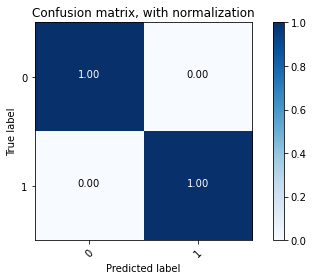

In [38]:
import itertools

# Grab true labels from the validation generator


# Generate confusion matrix

# labels = ['W', 'NW']
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


conf_mat1 = confusion_matrix(test_labels_text2, test_predictions2, labels = [0, 1], sample_weight=None)
conf_mat2 = confusion_matrix(train_labels_text2, train_predictions2, labels = [0, 1], sample_weight=None)
#print(conf_mat)

plot_confusion_matrix(conf_mat2, classes=[0, 1],
                      title='Confusion matrix, with normalization', normalize = True)

In [ ]:
from scikit-learn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, test_data_text, test_labels_text, labels=["non_support", "support", "unaligned"], sample_weight=None, normalize=None, display_labels=None, include_values=True, xticks_rotation='horizontal', values_format=None, cmap='viridis', ax=None)

In [ ]:



from keras.utils import plot_model
import graphviz
plot_model(model, to_file='feb_model.png')


# serialize model to JSON

"""
model_json = model.to_json()
with open("election_image_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("election_image_model.h5")
print("Saved model to disk")

"""






In [ ]:
from keras import backend as K
K.clear_session()